<a href="https://colab.research.google.com/github/nyquist/aoe2de/blob/main/AOE2DE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Config Replay

In [107]:
#game_id = "358345344" #"357732557"

To do.. how to get list of replays per user

In [108]:
import requests
#profile_id = "18446743"
relic_id = "222475"
#match_type = 4
#game = "age2"

#profile_url = f"https://www.ageofempires.com/stats/?profileId={profile_id}&game={game}&matchType={match_type}"
profile_url = f"https://www.aoe2insights.com/user/{relic_id}/matches/"
response = requests.get(profile_url)
#print (response.status_code)
#print (response.headers)
import re
matches = re.finditer(r'href="/match/(\d+)/"', response.text)
games = []
for match in matches:
    found_game_id = match.group(1)
    games.append(found_game_id)
game_id = games[0]
print (game_id)



358345344


#Environment Setup

In [109]:
! [[ -d "aoe2de" ]] && (cd aoe2de && git pull) || git clone https://github.com/nyquist/aoe2de.git
! ls -la ./aoe2de/utils

remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 13 (delta 8), reused 5 (delta 3), pack-reused 0 (from 0)
Unpacking objects: 100% (13/13), 1.06 MiB | 3.38 MiB/s, done.
From https://github.com/nyquist/aoe2de
   7c13093..d4fbd1c  main       -> origin/main
Updating 7c13093..d4fbd1c
Fast-forward
 AOE2DE.ipynb                   | 160 +++++++++++++++++++++++++++++++++++++------------------------
 mtmExtractBuildingsfromJson.py |   2 +-
 2 files changed, 99 insertions(+), 63 deletions(-)
total 12
drwxr-xr-x 2 root root 4096 Dec 14 18:18 .
drwxr-xr-x 5 root root 4096 Dec 14 22:19 ..
-rw-r--r-- 1 root root   22 Dec 14 18:18 test.py


In [110]:
import os

def list_files_with_dynamic_sizes(path="."):
    """Lists all files and their sizes with dynamic units (B, kB, MB, etc.) in the given directory.

    Args:
        path (str, optional): The directory path to list files from. Defaults to "." (current directory).
    """
    for entry in os.scandir(path):
        if entry.is_file():
            file_size = os.path.getsize(entry.path)
            unit_index = 0
            units = ["B", "kB", "MB", "GB", "TB"]
            while file_size >= 1024 and unit_index < len(units) - 1:
                file_size /= 1024
                unit_index += 1
            print(f"{entry.name}: {file_size:.2f} {units[unit_index]}")

# Call the function to list files and sizes with dynamic units in the current directory


# Download record

In [111]:
import requests

replay_url = f"https://aoe.ms/replay/?gameId={game_id}&profileId=18446743"  # Replace with the actual URL you copied

response = requests.get(replay_url)
response.raise_for_status()  # Raise an exception for bad responses
print (response.status_code)
content_disposition = response.headers['Content-Disposition']
import re
match = re.search(r'filename="?([^";]+)"?', content_disposition)
if match:
    file_name = match.group(1)
    print(f"Extracted filename: {file_name}")
    with open(file_name, "wb") as f:
      f.write(response.content)
else:
    print("Filename not found in Content-Disposition header.")


print(f"Replay file downloaded as {file_name}")
list_files_with_dynamic_sizes()





200
Extracted filename: AgeIIDE_Replay_358345344.zip
Replay file downloaded as AgeIIDE_Replay_358345344.zip
AgeIIDE_Replay_358331220.aoe2record.json: 16.02 MB
AgeIIDE_Replay_358106354.zip: 1.54 MB
AgeIIDE_Replay_357732557.zip: 1.37 MB
AgeIIDE_Replay_357732557.aoe2record: 3.09 MB
AgeIIDE_Replay_358345344.aoe2record: 3.16 MB
AgeIIDE_Replay_358331220.aoe2record: 2.59 MB
AgeIIDE_Replay_357732557.aoe2record.json: 16.03 MB
AgeIIDE_Replay_358106354.aoe2record: 3.72 MB
AgeIIDE_Replay_358345344.zip: 1.48 MB
AgeIIDE_Replay_358345344.aoe2record.json: 21.61 MB
AgeIIDE_Replay_358331220.zip: 1.37 MB


### Unzip record file

In [112]:
zip_file_name = file_name
record_file_name = file_name.replace(".zip", ".aoe2record")

import zipfile

try:
    with zipfile.ZipFile(zip_file_name, 'r') as zip_ref:
        zip_ref.extractall(".")  # Extract all files to the current directory
    print(f"Successfully extracted files from {zip_file_name}")

    # Find the extracted replay file (assuming it's an .mgz file)
    extracted_file_name = None
    for filename in os.listdir("."):
        print (filename)
        if filename == record_file_name:
            extracted_file_name = filename
            break

    if extracted_file_name:
        # Process the extracted replay file
        print ("Extracted file:", extracted_file_name)
    else:
        print("Error: Could not find extracted replay file (.mgz).")

except zipfile.BadZipFile:
    print(f"Error: {zip_file_name} is not a valid zip file.")
except FileNotFoundError:
    print(f"Error: {zip_file_name} not found.")
except RuntimeError as e:
    if "could not parse" in str(e):
        print(f"Error parsing the replay file: {e}")
        print("The replay file might be corrupted or in an unsupported format.")
        print("Please try re-downloading the replay file or using a different one.")
    else:
        raise  # Re-raise the exception if it's not related to parsing

Successfully extracted files from AgeIIDE_Replay_358345344.zip
.config
AgeIIDE_Replay_358331220.aoe2record.json
AgeIIDE_Replay_358106354.zip
AgeIIDE_Replay_357732557.zip
AgeIIDE_Replay_357732557.aoe2record
AgeIIDE_Replay_358345344.aoe2record
Extracted file: AgeIIDE_Replay_358345344.aoe2record


## Convert file to json

In [113]:
import json
! pip install mgz
from mgz.model import parse_match, serialize
f = extracted_file_name
outFile=f"{extracted_file_name}.json"
print (f)
with open(f, 'rb') as h:
    match = parse_match(h)
    # print(json.dumps(serialize(match), indent=2))
    json_object=json.dumps(serialize(match), indent=2)
    with open(outFile, "w") as o:
        o.write(json_object)

list_files_with_dynamic_sizes()

AgeIIDE_Replay_358345344.aoe2record
AgeIIDE_Replay_358331220.aoe2record.json: 16.02 MB
AgeIIDE_Replay_358106354.zip: 1.54 MB
AgeIIDE_Replay_357732557.zip: 1.37 MB
AgeIIDE_Replay_357732557.aoe2record: 3.09 MB
AgeIIDE_Replay_358345344.aoe2record: 3.16 MB
AgeIIDE_Replay_358331220.aoe2record: 2.59 MB
AgeIIDE_Replay_357732557.aoe2record.json: 16.03 MB
AgeIIDE_Replay_358106354.aoe2record: 3.72 MB
AgeIIDE_Replay_358345344.zip: 1.48 MB
AgeIIDE_Replay_358345344.aoe2record.json: 21.61 MB
AgeIIDE_Replay_358331220.zip: 1.37 MB


# Analysis

In [114]:
with open(outFile, 'r') as json_file:
    json_data = json.load(json_file)

## Buildings

In [115]:
#! head aoe2de/mtmExtractBuildingsfromJson.py

from aoe2de.mtmExtractBuildingsfromJson import BuildingsAnalyzer

buildings = BuildingsAnalyzer(outFile)

email_to_mihai 1
nyquist 3
gabisan 5
risk 7
CANAFARCI 2
衝浪小王子 4
sHmOoPie :) 6
球球你别跑 8
['email_to_mihai', 'CANAFARCI', 'nyquist', '衝浪小王子', 'gabisan', 'sHmOoPie :)', 'risk', '球球你别跑']
[{}, {}, {}, {}, {}, {}, {}, {}]
+----------------+----------------+-----------+---------+------------+---------+-------------+------+------------+
|    Cladire     | email_to_mihai | CANAFARCI | nyquist | 衝浪小王子 | gabisan | sHmOoPie :) | risk | 球球你别跑 |
+----------------+----------------+-----------+---------+------------+---------+-------------+------+------------+
|     House      |       37       |     47    |    35   |     41     |    45   |      43     |  28  |     47     |
|  Lumber Camp   |       4        |     4     |    8    |     8      |    4    |      5      |  5   |     7      |
| Palisade Wall  |       4        |     8     |    3    |     1      |    2    |      2      |  0   |     12     |
|      Mill      |       1        |     2     |    1    |     6      |    3    |      3      |  1   |     

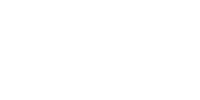

## Army